In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import UsefulFunctions as uf
from obspy import UTCDateTime
from obspy import Trace
from obspy import Stream
from obspy.clients.fdsn import Client
from obspy.core.inventory.inventory import Inventory
from obspy.signal.filter import envelope

In [2]:
# Earthquake variables
# eq = uf.Earthquake(f'{uf.DATA_PATH}/AncScenarioGrids/Anc2018.xml')
eq = uf.Earthquake(f'{uf.DATA_PATH}/4grid.xml')
eq_lat = eq.event['lat']
eq_lon = eq.event['lon']
eq_dep = eq.event['depth']


Start of Parsing for /home/afozkos/PycharmProjects/ShakeMapsProcessor/Data/4grid.xml
   ~~Detection stats~~
    Used a maximum azimuthal gap of 300 degrees and minimum station vector angle of 30 km
    Number of stations needed: 4
    Detection Time: 13.682719094014004
    Azimuthal Gap: 231.11376365473495
    Max Vector Angle: 83.27830231037471
    Maximum Epicentral Distance: 67.98464703929608
Finished parsing grid.xml for: M3.9, 36 km (22 miles) SW of Willow, at 2023-02-16T23:32:34 (ID:ak02326457m5)


In [244]:
# ObsPY variables
client_wm = Client("IRIS")
of = 'Plots/test.png'
station_names = ['K203', 'CAPN', 'GHO', 'VMT', 'DIV']
station_data = {}
st = Stream()
inv = Inventory()
# Define channel, network, origin time, and time range for waveforms
chan = 'BH*'
net = 'AK'
# or_time = '2018-11-30T17:29:29.000Z'
or_time = '2023-02-16T23:32:34.000Z'
or_time = UTCDateTime(or_time)
starttime = or_time
endtime = or_time + 120

# Loop over each station we want information from/for
for name in station_names:

    # Attempt to get waveform data
    try:
        st_cur = client_wm.get_waveforms(net, name, "*", chan, starttime, endtime)
        inv_cur = client_wm.get_stations(network=net, station=name, location="*", channel=chan, starttime=starttime,
                                         endtime=endtime, level='response')
        st += st_cur
        inv += inv_cur
    except:
        print(f'Error getting data from {name}')
        continue

    # Get location of current station
    lat = inv_cur[0][0].latitude
    lon = inv_cur[0][0].longitude
    # Find closest grid point in ShakeMap grid and pga
    subtracted_list = np.hstack((eq.lats - lat, eq.lons - lon))
    nearest_index = np.nanargmin(np.sum(subtracted_list**2, axis=1))
    pga = eq.pga[nearest_index, 0]
    # Calculate epicentral and hypocentral distance, and first-arrival times
    epi_dist = uf.getDistance(eq_lat, eq_lon, lat, lon)
    hypo_dist = (epi_dist**2 + eq_dep**2)**.5
    p_arr = hypo_dist/eq.vel_p
    s_arr = hypo_dist/eq.vel_s
    surf_arr = hypo_dist/eq.vel_surf
    # Save the info into the data dict
    station_data[name] = {'lat': lat,
                          'lon': lon,
                          'epi_dist': epi_dist,
                          'hypo_dist': hypo_dist,
                          'pga': pga,
                          'p_arr': p_arr,
                          's_arr': s_arr,
                          'surf_arr': surf_arr}

# # Loop over each station we want information from/for
# for name in station_names:

#     # Attempt to get waveform data
#     try:
#         st_cur = client_wm.get_waveforms(net, name, "*", chan, starttime, endtime)
#         inv_cur = client_wm.get_stations(network=net, station=name, location="*", channel=chan, starttime=starttime,
#                                          endtime=endtime, level='response')
#         st += st_cur
#         inv += inv_cur
#     except:
#         print(f'Error getting data from {name}')
#         continue

# for i in range(len(inv[0])):
#     inv_cur = inv[0][i]
#     code = inv_cur.code
#     # Get location of current station
#     lat = inv_cur.latitude
#     lon = inv_cur.longitude
#     # Find closest grid point in ShakeMap grid and pga
#     subtracted_list = np.hstack((eq.lats - lat, eq.lons - lon))
#     nearest_index = np.nanargmin(np.sum(subtracted_list**2, axis=1))
#     pga = eq.pga[nearest_index, 0]
#     # Calculate epicentral and hypocentral distance, and first-arrival times
#     epi_dist = uf.getDistance(eq_lat, eq_lon, lat, lon)
#     hypo_dist = (epi_dist**2 + eq_dep**2)**.5
#     p_arr = hypo_dist/eq.vel_p
#     s_arr = hypo_dist/eq.vel_s
#     surf_arr = hypo_dist/eq.vel_surf
#     # Save the info into the data dict
#     station_data[code] = {'lat': lat,
#                           'lon': lon,
#                           'epi_dist': epi_dist,
#                           'hypo_dist': hypo_dist,
#                           'pga': pga,
#                           'p_arr': p_arr,
#                           's_arr': s_arr,
#                           'surf_arr': surf_arr}


Error getting data from K203


/tmp/ipykernel_31342/3113270186.py:18: RuntimeWarning: divide by zero encountered in true_divide
  v_app = distance/tr_e.times()
/tmp/ipykernel_31342/3113270186.py:18: RuntimeWarning: divide by zero encountered in true_divide
  v_app = distance/tr_e.times()
/tmp/ipykernel_31342/3113270186.py:18: RuntimeWarning: divide by zero encountered in true_divide
  v_app = distance/tr_e.times()
/tmp/ipykernel_31342/3113270186.py:18: RuntimeWarning: divide by zero encountered in true_divide
  v_app = distance/tr_e.times()


Text(0.5, 0, 'Velocity (km/s)')

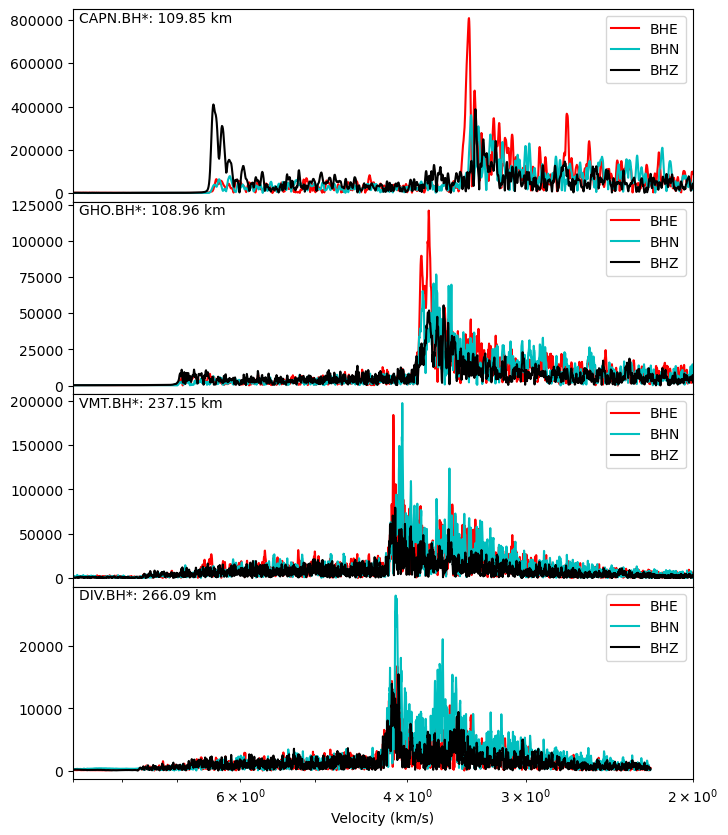

In [259]:
n_tr = len(st)
st1 = st.copy()

st_acc = st.copy()
st_acc.attach_response(inv)
st_acc = st_acc.remove_response(output='ACC')

fig, ax = plt.subplots(nrows=n_tr // 3, sharex=True, figsize=(8,10))
fig.subplots_adjust(hspace=0)
for i in range(n_tr // 3):
    code = st1[i*3].stats.station
    # chan = st1[i].stats.channel
    distance = station_data[code]['hypo_dist']
    tr_e = st1[i*3].detrend('demean')
    tr_n = st1[i*3 + 1].detrend('demean')
    tr_z = st1[i*3 + 2].detrend('demean')
    tr_max = np.max(np.abs([tr_e, tr_n, tr_z]))
    v_app = distance/tr_e.times()
    ax[i].plot(v_app, envelope(tr_e.data), c='r', label=tr_e.stats.channel)
    ax[i].plot(v_app, envelope(tr_n.data), c='c', label=tr_n.stats.channel)
    ax[i].plot(v_app, envelope(tr_z.data), c='k', label=tr_z.stats.channel)

    ax[i].text(.01, .99, '%s.%s: %.2f km' % (code, chan, distance), ha='left', va='top', transform=ax[i].transAxes)
    ax[i].legend(loc='upper right')
    # ax[i].set_title('%s: %.2f km' % (code, distance))
plt.xscale('log')
plt.xlim(9, 2)
plt.xlabel('Velocity (km/s)')


/home/afozkos/.conda/envs/ShakeMaps/lib/python3.9/site-packages/obspy/signal/filter.py:206: RuntimeWarning: invalid value encountered in sqrt
  data = (data ** 2 + hilb ** 2) ** 0.5
/home/afozkos/.conda/envs/ShakeMaps/lib/python3.9/site-packages/obspy/signal/filter.py:206: RuntimeWarning: invalid value encountered in sqrt
  data = (data ** 2 + hilb ** 2) ** 0.5
/home/afozkos/.conda/envs/ShakeMaps/lib/python3.9/site-packages/obspy/signal/filter.py:206: RuntimeWarning: invalid value encountered in sqrt
  data = (data ** 2 + hilb ** 2) ** 0.5


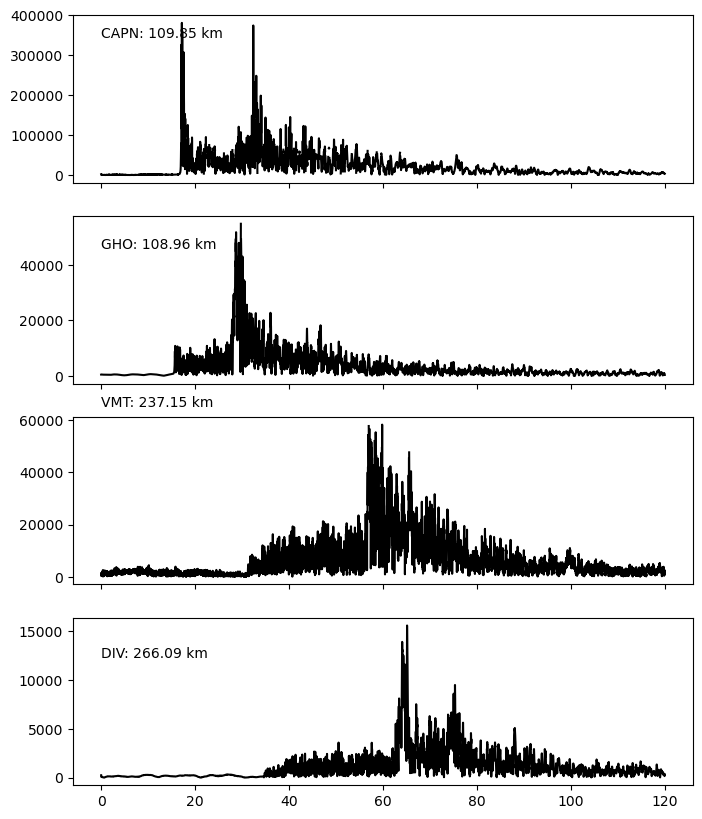

In [224]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8,10))
for i in range(4):
    code = st1[i].stats.station
    distance = station_data[code]['hypo_dist']
    v_app = distance/st1[i].times()[1:]
    ax[i].plot(st1[i].times(), envelope(st[i].data), c='k')
    ax[i].text(0, np.max(st[i].data[1:])-1000, '%s: %.2f km' % (code, distance), va='top')

In [122]:
st[0].stats.station

'CDVT'

In [213]:
len(st)

4

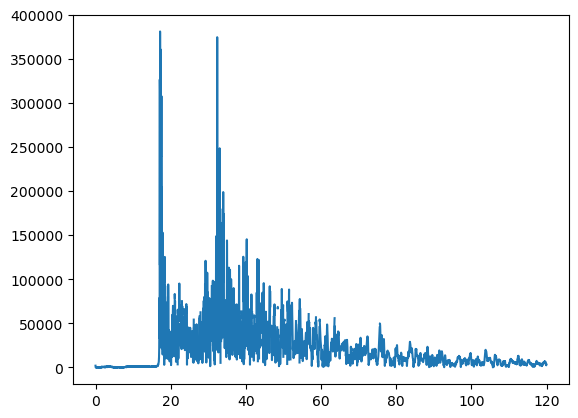

In [221]:
plt.figure()
plt.plot(st1[0].times(), envelope(st1[0].data))

In [245]:
st

12 Trace(s) in Stream:
AK.CAPN..BHE | 2023-02-16T23:32:34.008393Z - 2023-02-16T23:34:33.988393Z | 50.0 Hz, 6000 samples
AK.CAPN..BHN | 2023-02-16T23:32:34.008393Z - 2023-02-16T23:34:33.988393Z | 50.0 Hz, 6000 samples
AK.CAPN..BHZ | 2023-02-16T23:32:34.008393Z - 2023-02-16T23:34:33.988393Z | 50.0 Hz, 6000 samples
AK.GHO..BHE  | 2023-02-16T23:32:34.008394Z - 2023-02-16T23:34:33.988394Z | 50.0 Hz, 6000 samples
AK.GHO..BHN  | 2023-02-16T23:32:34.008393Z - 2023-02-16T23:34:33.988393Z | 50.0 Hz, 6000 samples
AK.GHO..BHZ  | 2023-02-16T23:32:34.008394Z - 2023-02-16T23:34:33.988394Z | 50.0 Hz, 6000 samples
AK.VMT..BHE  | 2023-02-16T23:32:34.008393Z - 2023-02-16T23:34:33.988393Z | 50.0 Hz, 6000 samples
AK.VMT..BHN  | 2023-02-16T23:32:34.008393Z - 2023-02-16T23:34:33.988393Z | 50.0 Hz, 6000 samples
AK.VMT..BHZ  | 2023-02-16T23:32:34.008393Z - 2023-02-16T23:34:33.988393Z | 50.0 Hz, 6000 samples
AK.DIV..BHE  | 2023-02-16T23:32:34.008393Z - 2023-02-16T23:34:33.988393Z | 50.0 Hz, 6000 samples
AK.DIV.